In [1079]:
from __future__ import division

import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import roc_curve, auc

import scipy.io as sio
import scipy.stats as stats

### Helper fcns

In [1080]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, norm=True):

    if norm:
        totals = cmat.sum(axis=1)
        totals = totals.T
        totals = np.expand_dims(totals,axis=1)
        totals = np.tile(totals,(1,2))
        cmat_norm = cmat/totals
        print(cmat_norm)
        cm = cmat_norm

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fall','Fall'], rotation=45)
    plt.yticks(tick_marks, ['Non-Fall','Fall'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [1081]:
def LOSOCV(X,y,data):

    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    thr = np.linspace(0,1,21)
    thr = thr[::-1]

    plt.figure(figsize=(8,6))

    TTPR_all, TFPR_all = [], []
    
    for train_index, test_index in subj.split(X, y, groups):
        Dtr = data.iloc[train_index]
        Dte = data.iloc[test_index]
        
        SensT, SpecT = ThresholdClass(Dtr,Dte)
        TTPR_all.append(SensT)
        TFPR_all.append(1-SpecT)
        
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        
        #selct features
        Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]

        forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False,class_weight=None)    
        forest.fit(Xtr,ytr)
        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]

        #acc = np.sum(ypred==yte)/len(ypred)
        #print('Acc = %.4f')%acc

    #    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1,drop_intermediate=False
        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec
        #Sens = sum((ypred==1) & (yte==1)) / sum(yte==1); Spec = 1-sum((ypred==1) & (yte==0)) / sum(yte==0)
        ind = np.argmax(tpr-fpr)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f'%(roc_auc,Sens,Spec))    
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)

        #plot each individual ROC
    #     lw = 2
    #     plt.plot(fpr, tpr, color='darkorange',
    #              lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    #     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Healthy-Healthy')
    #plt.legend(loc="lower right")

    #summary results
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))

    return AUC_all, fpr_all, tpr_all, Sens_all, Spec_all, TTPR_all, TFPR_all

In [1082]:
#Dtr and D are the corresponding train and test dataframes

def EvaluateBySubject(Dtr,D):

    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]; t_all=[]
    TTPR_all, TFPR_all = [], []
    TOpt_all, T90_all = [], []
    thr = np.linspace(0,1,21)
    thr = thr[::-1]

    #train and test data as numpy arrays
    Xtr = Dtr.iloc[:,4:].as_matrix()
    ytr = Dtr.Falltype.as_matrix()
    X = D.iloc[:,4:].as_matrix()
    y = D.Falltype.as_matrix()

    #select train features and train on the population in Xtr
    Xtr = Xtr[:,indmax]
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False,class_weight=None)    
    forest.fit(Xtr,ytr)
    
    #split by subject for testing on X,y
    groups = D.SubjID.as_matrix()
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    
    for train_index, test_index in subj.split(X, y, groups):
        
        Dte = D.iloc[test_index]
            
        SensT, SpecT = ThresholdClass(Dtr,Dte)
        TTPR_all.append(SensT)
        TFPR_all.append(1-SpecT)
        
        Xte = X[test_index]
        yte = y[test_index]
        
        #selct test features
        Xte = Xte[:,indmax]

        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]

#         print(np.percentile(yscore[yte==1],[5, 10, 15, 20]))
        
        #acc = np.sum(ypred==yte)/len(ypred)
        #print('Acc = %.4f')%acc

    #    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1,drop_intermediate=False
        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            t_all.append(t)
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec
        #Sens = sum((ypred==1) & (yte==1)) / sum(yte==1); Spec = 1-sum((ypred==1) & (yte==0)) / sum(yte==0)
        ind = np.argmax(tpr-fpr,axis=0)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        ## Thresholds
        TOpt_all.append(t_all[ind])
        T90_all.append(t_all[np.argmin(abs(tpr-.90))])
        
        TOpt = np.mean(TOpt_all)
        T90 = np.mean(T90_all)
        
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f'%(roc_auc,Sens,Spec))    
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)

    #summary results
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))

    return AUC_all, fpr_all, tpr_all, Sens_all, Spec_all, TTPR_all, TFPR_all, TOpt, T90

In [1083]:
def HomeDataEval(Dtr,D,Threshold):

    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]; t_all=[]
    TTPR_all, TSpec_all = [], []
    FPCount_all, TFPCount_all = [], []
    thr = np.linspace(0,1,21)
    thr = thr[::-1]

    #train and test data as numpy arrays
    Xtr = Dtr.iloc[:,4:].as_matrix()
    ytr = Dtr.Falltype.as_matrix()
    X = D.iloc[:,4:].as_matrix()
    y = D.Falltype.as_matrix()

    #select train features and train on the population in Xtr
    Xtr = Xtr[:,indmax]
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False,class_weight=None)    
    forest.fit(Xtr,ytr)
    
    #split by subject for testing on X,y
    groups = D.SubjID.as_matrix()
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    
    for train_index, test_index in subj.split(X, y, groups):
        
        Dte = D.iloc[test_index]
            
        _, SpecT = ThresholdClass(Dtr,Dte)
        TSpec_all.append(SpecT)
        
        Xte = X[test_index]
        yte = y[test_index]
        
        #selct test features
        Xte = Xte[:,indmax]

        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]
        
        #compute Sens and Spec
        Sens = sum((yscore>Threshold) & (yte==1)) / sum(yte==1); Spec = 1-sum((yscore>Threshold) & (yte==0)) / sum(yte==0)
        
        Spec_all.append(Spec)

    return Spec_all, TSpec_all

In [1084]:
current_palette = sns.color_palette()

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    
    return ax

In [1085]:
def ThresholdClass(TrainData,TestData):
    """Inputs: Dataframe containing AccMax and AccMin accelerations for both train and test data
    Outputs: dataframe of classification of test data as fall (True) or non-fall (False)"""
    Max = TrainData.AccMax
    Min = TrainData.AccMin
    UFT = Max[TrainData.Falltype==1].min(axis=0)
    LFT = Min[TrainData.Falltype==1].max(axis=0)
    
    ThresPred = (TestData.AccMax>UFT) & (TestData.AccMin<LFT)
    Sens = len(ThresPred[(ThresPred==True) & (TestData.Falltype==1)])/len(ThresPred[TestData.Falltype==1])
    Spec = len(ThresPred[(ThresPred==False) & (TestData.Falltype==0)])/len(ThresPred[TestData.Falltype==0])
    
    return Sens, Spec

    

### Load the data

In [1086]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [1087]:
#Subjtype: 0 = Amputee, 1 = Healthy , 2 = Healthy outdoor
Healthy.head(5)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,-0.135490,0.023986,-0.22209,-0.034934,0.026296,0.061168,...,1.3975,1.0539,1.371,0.57013,0.042151,0.040205,0.036391,0.082633,0.057698,0.142730
1,1,1,1,3,-0.116930,0.041788,-0.25966,-0.036706,0.028857,0.069082,...,1.0056,-1.0666,1.371,0.59226,0.044890,0.055954,0.064699,0.077030,0.105940,0.130800
2,1,1,1,3,-0.095297,-0.009186,-0.26274,-0.031153,0.019380,0.071339,...,1.5987,2.0886,1.371,0.76639,0.050949,0.099145,0.054502,0.070348,0.107280,0.145240
3,1,1,1,4,-0.131590,0.012601,0.36066,-0.030360,0.038864,0.070713,...,2.0909,4.4104,1.371,0.51069,0.035452,0.046974,0.043586,0.073470,0.071604,0.098844
4,1,1,1,4,-0.174220,0.002581,0.33938,-0.049466,0.017201,0.068173,...,2.0293,4.1421,1.371,0.50332,0.045742,0.077608,0.067755,0.079449,0.131450,0.085266


In [1088]:
print(len(Healthy))
print(len(Amp))

4890
2184


In [1089]:
print(('N subjects Healthy: %s'%(len(Healthy.SubjID.unique()))))
print(('N subjects Amp: %s'%(len(Amp.SubjID.unique()))))
print(Healthy.Subjtype.unique())
print(Amp.Subjtype.unique())

N subjects Healthy: 10
N subjects Amp: 7
[1]
[0]


In [1090]:
#Healthy
print(('Nfalls = %s')%(len(Healthy[Healthy.Falltype<9])))
print(('Nactivities = %s')%(len(Healthy[Healthy.Falltype==9])))

Nfalls = 4575
Nactivities = 315


In [1091]:
#Amp
print(('Nfalls = %s')%(len(Amp[Amp.Falltype<9])))
print(('Nactivities = %s')%(len(Amp[Amp.Falltype==9])))

Nfalls = 1877
Nactivities = 307


In [1092]:
#selecting cols by index
Healthy.iloc[1:5, 0:4]

,SubjID,Loc,Subjtype,Falltype
1,1,1,1,3
2,1,1,1,3
3,1,1,1,4
4,1,1,1,4


# Train on healthy and test on amputees

In [1093]:
#transform to binary class
Xtr = Healthy.iloc[:,4:].as_matrix()
ytr = Healthy.Falltype.as_matrix()
Xte = Amp.iloc[:,4:].as_matrix()
yte = Amp.Falltype.as_matrix()
ytr[ytr < 9] = 1
ytr[ytr == 9] = 0
yte[yte < 9] = 1
yte[yte == 9] = 0

In [1094]:
print(Xtr.shape)
print(np.unique(ytr))
print(Xte.shape)
print(np.unique(yte))

(4890, 1211)
[0 1]
(2184, 1211)
[0 1]


In [1095]:
forest = RandomForestClassifier(n_estimators=50,random_state=10)
forest.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [1096]:
importance = forest.feature_importances_
print(importance)
indices = np.argsort(importance)
importance_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
print(importance_std)

[  7.84592319e-05   1.42374638e-04   1.42221890e-04 ...,   1.29468126e-06
   3.87604949e-04   1.70145129e-04]
[  5.49214623e-04   8.87375169e-04   6.96872789e-04 ...,   6.42328644e-06
   1.49728194e-03   1.19101590e-03]


In [1097]:
importance_norm = importance/np.max(importance)

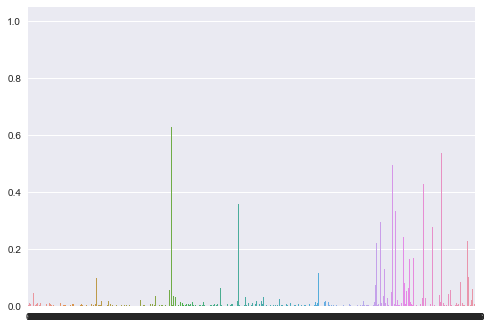

In [1098]:
#using Seaborn
sns.set_context("notebook")
ax = sns.barplot(x=indices,y=importance_norm[indices])
plt.figure(figsize=(8,6))

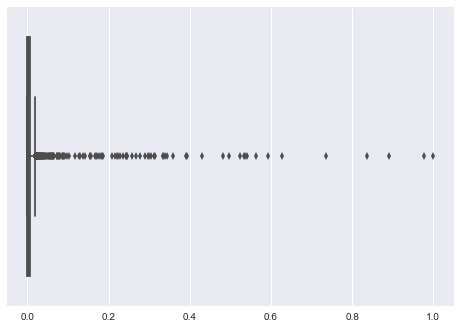

In [1099]:
ax = sns.boxplot(importance_norm)
plt.figure(figsize=(8,6))

In [1100]:
qc = np.percentile(importance_norm,[75])
print(1.5*qc)

[ 0.01101271]


In [1101]:
# indmax = np.argwhere(importance_norm >= 1.5*qc)
indmax = np.argwhere(importance_norm >= 0.1)
indmax = indmax.reshape(-1)
print(len(indmax))
print(indmax)

57
[  12  183  184  338  344  386  387  388  423  492  520  569  570  599  780
  785  786  787  940  944  945  946  948  955  956  957  966  971  972  986
  988  989  990  996 1011 1018 1034 1045 1046 1047 1048 1070 1071 1072 1096
 1120 1121 1122 1144 1146 1147 1190 1191 1194 1195 1200 1204]


In [1102]:
forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False,class_weight=None)
forest.fit(Xtr[:,indmax],ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [1103]:
ypred = forest.predict(Xte[:,indmax])
yscore = forest.predict_proba(Xte[:,indmax])
yscore = yscore[:,1]

In [1104]:
#acc = np.sum(ypred==yte)/len(ypred)
#print('Acc = %.3f')%acc
fprHA, tprHA, thresholdsHA = metrics.roc_curve(yte, yscore, pos_label=1)
roc_aucHA = auc(fprHA, tprHA)
print('AUC = %.3f'%roc_aucHA)

AUC = 0.989


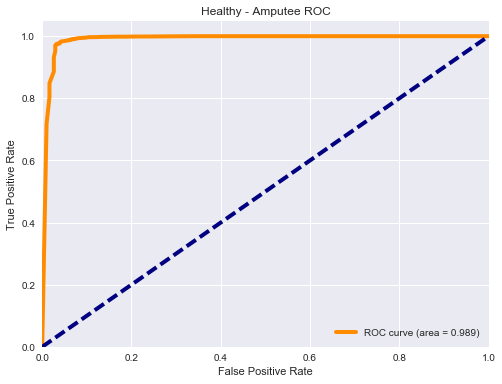

In [1105]:
plt.figure(figsize=(8,6))
lw = 4
plt.plot(fprHA, tprHA, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_aucHA)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - Amputee ROC')
plt.legend(loc="lower right")
sns.set_context('poster')

### Threshold Method

In [1106]:
Healthy = Healthy.rename(index=int,columns={950:'AccMax',951:'AccMin'})
Amp = Amp.rename(index=int,columns={950:'AccMax',951:'AccMin'})
[Sens, Spec] = ThresholdClass(Healthy,Amp)

In [1107]:
print (Sens)
print (Spec)

1.0
0.18892508143322476


# LOSO CV on Healthy

In [1108]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})

In [1109]:
from sklearn.model_selection import LeaveOneGroupOut

In [1110]:
#Subjects with indoor and outdoor falls
print(np.sort(Healthy[Healthy.Subjtype == 1].SubjID.unique()))
print(np.sort(Healthy[Healthy.Subjtype == 2].SubjID.unique()))

[ 1  2  3  4  5  6  7  8  9 10]
[]


In [1111]:
#drop subject 3 
Healthy = Healthy[Healthy.SubjID!=3]
Healthy.SubjID.unique()

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [1112]:
Healthy.shape

(4474, 1215)

In [1113]:
#binarize labels
X = Healthy.iloc[:,4:].as_matrix()
y = Healthy.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0

In [1114]:
np.unique(y)

array([0, 1], dtype=int64)

In [1115]:
print(X.shape)
print(y.shape)

(4474, 1211)
(4474,)


In [1116]:
groups = Healthy.SubjID.as_matrix()
print(groups.shape)
print(np.unique(groups))

(4474,)
[ 1  2  4  5  6  7  8  9 10]


In [1117]:
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

9

In [1118]:
indmax #602 gyro features + 602 accelerometer

array([  12,  183,  184,  338,  344,  386,  387,  388,  423,  492,  520,
        569,  570,  599,  780,  785,  786,  787,  940,  944,  945,  946,
        948,  955,  956,  957,  966,  971,  972,  986,  988,  989,  990,
        996, 1011, 1018, 1034, 1045, 1046, 1047, 1048, 1070, 1071, 1072,
       1096, 1120, 1121, 1122, 1144, 1146, 1147, 1190, 1191, 1194, 1195,
       1200, 1204], dtype=int64)

In [1119]:
## Use Magnitude Features Only
indmax = np.linspace(336,355,20)
indmax = np.hstack([indmax,np.linspace(336,355,20)+602])
indmax = indmax.astype(int)

In [1120]:
#sanity check
for train_index, test_index in subj.split(X, y, groups):
    Xtr,Xte = X[train_index],X[test_index]
    ytr = y[train_index]
    Xtr,Xte = Xtr[:,indmax],Xte[:,indmax]
    print(Xtr.shape,Xte.shape,ytr.shape)

(4107, 40) (367, 40) (4107,)
(3787, 40) (687, 40) (3787,)
(3918, 40) (556, 40) (3918,)
(4102, 40) (372, 40) (4102,)
(3740, 40) (734, 40) (3740,)
(4127, 40) (347, 40) (4127,)
(3852, 40) (622, 40) (3852,)
(4051, 40) (423, 40) (4051,)
(4108, 40) (366, 40) (4108,)


In [1121]:
print(Healthy.shape)
print(X.shape)

(4474, 1215)
(4474, 1211)


In [1122]:
AUC_all_HH, fpr_all_HH, tpr_all_HH, Sens_all_HH, Spec_all_HH, TTPR_all_HH, TFPR_all_HH = LOSOCV(X,y,Healthy)

AUC = 0.9984, Sens = 0.9650, Spec = 1.0000
AUC = 0.9771, Sens = 0.8899, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9978, Sens = 0.9928, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9995, Sens = 0.9848, Spec = 1.0000
AUC = 0.9588, Sens = 0.9400, Spec = 0.9700
AUC = 0.9918, Sens = 0.9970, Spec = 0.9400
mean AUC = 0.992 (+/- 0.027)
mean Sens = 0.974 (+/- 0.071)
mean Spec = 0.990 (+/- 0.040)


In [1123]:
TTPR_all_HH = np.asarray(TTPR_all_HH)
TFPR_all_HH = np.asarray(TFPR_all_HH)

tprmuHH = np.mean(TTPR_all_HH)
tprerrHH = np.std(TTPR_all_HH)/math.sqrt(len(TTPR_all_HH))*1.96
fprmuHH = np.mean(TFPR_all_HH)
fprerrHH = np.std(TFPR_all_HH)/math.sqrt(len(TFPR_all_HH))*1.96

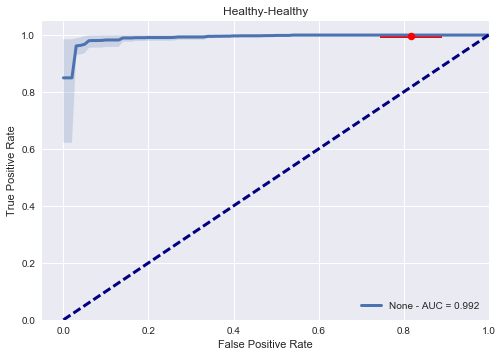

In [1124]:
sns.set_context('notebook')
AX = None
AX = plot_roc(tpr_all_HH,fpr_all_HH,np.mean(AUC_all_HH))
AX.errorbar(fprmuHH,tprmuHH,xerr = fprerrHH,yerr = tprerrHH, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=4)
AX.set_title('Healthy-Healthy')

In [1125]:
HX = X
Hy = y

# LOSO CV on Amputees

**Note: SubjID 2 does not have activities**

In [1126]:
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype', 950:'AccMax',951:'AccMin'})

In [1127]:
Amp[Amp.SubjID ==2].Falltype.unique()

array([4, 3, 2, 1], dtype=int64)

In [1128]:
Amp = Amp[Amp.SubjID != 2] #drop subj 2

In [1129]:
X = Amp.iloc[:,4:].as_matrix()
y = Amp.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0
groups = Amp.SubjID.as_matrix()
print(groups.shape)
print(np.sort(np.unique(groups)))
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

(1844,)
[1 3 4 5 6 7]


6

In [1130]:
#sanity check
for train_index, test_index in subj.split(X, y, groups):
    Xtr,Xte = X[train_index],X[test_index]
    ytr = y[train_index]
    Xtr,Xte = Xtr[:,indmax],Xte[:,indmax]
    print(Xtr.shape,Xte.shape,ytr.shape)

(1582, 40) (262, 40) (1582,)
(1435, 40) (409, 40) (1435,)
(1450, 40) (394, 40) (1450,)
(1573, 40) (271, 40) (1573,)
(1732, 40) (112, 40) (1732,)
(1448, 40) (396, 40) (1448,)


In [1131]:
AUC_all_AA, fpr_all_AA, tpr_all_AA, Sens_all_AA, Spec_all_AA, TTPR_allAA, TFPR_allAA = LOSOCV(X,y,Amp)

AUC = 0.9888, Sens = 1.0000, Spec = 0.9200
AUC = 0.9969, Sens = 1.0000, Spec = 0.9600
AUC = 0.9999, Sens = 0.9943, Spec = 1.0000
AUC = 0.9837, Sens = 0.9442, Spec = 0.9400
AUC = 0.9829, Sens = 0.9714, Spec = 0.9500
AUC = 0.9980, Sens = 0.9819, Spec = 0.9800
mean AUC = 0.992 (+/- 0.014)
mean Sens = 0.982 (+/- 0.040)
mean Spec = 0.958 (+/- 0.052)


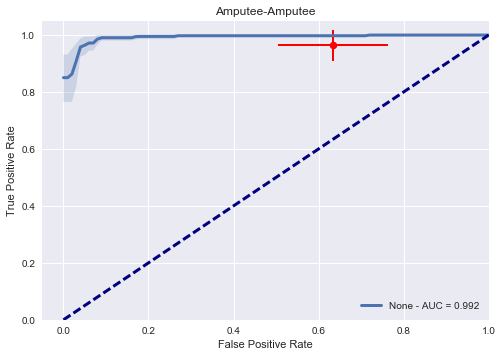

In [1132]:
TTPR_allAA = np.asarray(TTPR_allAA)
TFPR_allAA = np.asarray(TFPR_allAA)

tprmuAA = np.mean(TTPR_allAA)
tprerrAA = np.std(TTPR_allAA)/math.sqrt(len(TTPR_allAA))*1.96
fprmuAA = np.mean(TFPR_allAA)
fprerrAA = np.std(TFPR_allAA)/math.sqrt(len(TFPR_allAA))*1.96

AX = plot_roc(tpr_all_AA,fpr_all_AA,np.mean(AUC_all_AA))
AX.errorbar(fprmuAA,tprmuAA,xerr = fprerrAA,yerr = tprerrAA, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=2)
AX.set_title('Amputee-Amputee')

# Healthy to Amputee w/ folds 

In [1133]:
AUC_all_HA, fpr_all_HA, tpr_all_HA, Sens_all_HA, Spec_all_HA, TTPR_allHA, TFPR_allHA, TOpt, T90 = EvaluateBySubject(Healthy,Amp)

AUC = 0.9946, Sens = 1.0000, Spec = 0.9200
AUC = 0.9819, Sens = 0.9827, Spec = 0.9500
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9773, Sens = 0.9256, Spec = 0.9200
AUC = 0.9659, Sens = 0.9571, Spec = 0.8800
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
mean AUC = 0.987 (+/- 0.025)
mean Sens = 0.978 (+/- 0.056)
mean Spec = 0.945 (+/- 0.088)


In [1134]:
TOpt

0.49666666666666676

(0.1, 1.1)

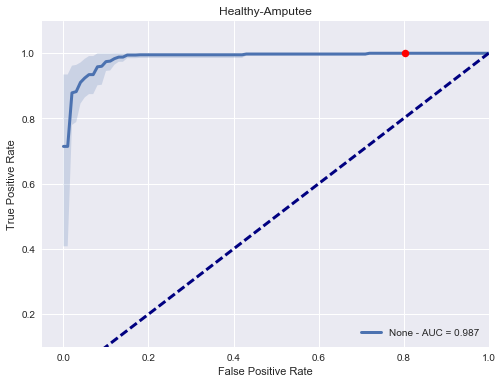

In [1135]:
TTPR_allHA = np.asarray(TTPR_allHA)
TFPR_allHA = np.asarray(TFPR_allHA)

tprmuHA = np.mean(TTPR_allHA)
tprerrHA = np.std(TTPR_allHA)/math.sqrt(len(TTPR_allHA))*1.96
fprmuHA = np.mean(TFPR_allHA)
fprerrHA = np.std(TFPR_allHA)/math.sqrt(len(TFPR_allHA))*1.96

plt.figure(figsize=(8,6))
AX = plot_roc(tpr_all_HA,fpr_all_HA,np.mean(AUC_all_HA))
AX.errorbar(fprmuHA,tprmuHA,xerr = fprerrHA,yerr = tprerrHA, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=2)
AX.set_title('Healthy-Amputee')
plt.ylim([0.1,1.1])

In [1136]:
[t_value, p_value] = stats.ttest_rel(AUC_all_HA,AUC_all_AA)
print('HA vs. AA %0.3f'%(p_value))

[t_value, p_value] = stats.ttest_ind(AUC_all_HH,AUC_all_HA)
print('HH vs. HA %0.3f'%(p_value))

HA vs. AA 0.242
HH vs. HA 0.523


In [1137]:
dataroc= [[tpr_all_HH,fpr_all_HH,AUC_all_HH,fprmuHH,tprmuHH,fprerrHH,tprerrHH],
          [tpr_all_HA,fpr_all_HA,AUC_all_HA,fprmuHA,tprmuHA,fprerrHA,tprerrHA],
          [tpr_all_AA,fpr_all_AA,AUC_all_AA,fprmuAA,tprmuAA,fprerrAA,tprerrAA]]

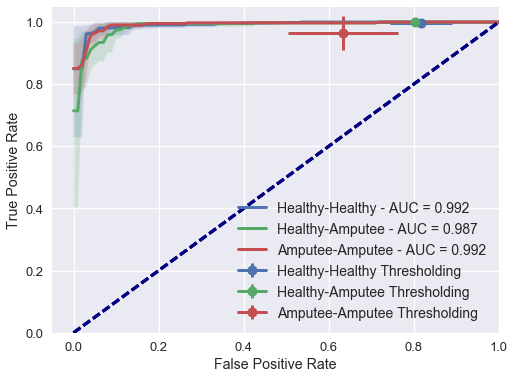

In [1138]:
AX.errorbar(fprmuAA,tprmuAA,xerr = fprerrAA,yerr = tprerrAA, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=2)


population = ['Healthy-Healthy','Healthy-Amputee','Amputee-Amputee']
fig = plt.figure(figsize=(8,6))
ax1=None
sns.set_context('talk')
for index,value in enumerate(population):
    ax1 = plot_roc(dataroc[index][0],dataroc[index][1],np.mean(dataroc[index][2]),plotname=value,
                   col=current_palette[index],ax=ax1)
    
    ax1.errorbar(dataroc[index][3],dataroc[index][4],xerr = dataroc[index][5],yerr = dataroc[index][6], 
                 ecolor = current_palette[index],
                 marker='.',mec=current_palette[index],mfc=current_palette[index],ms=20,lw=3,
                 color = current_palette[index],
                 label='%s Thresholding' %(value))
    
ax1.legend(loc='lower right',fontsize = 14)

In [1139]:
fig = ax1.get_figure()
fig.savefig('./Figs/Fig2.jpg')

In [1140]:
ax.get_legend_handles_labels()

([], [])

# Location Analysis

## Train on all locs (Healthy) and test on each location (Waist, Pocket and Hand) for amputees

AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9493, Sens = 1.0000, Spec = 0.8900
AUC = 0.9756, Sens = 0.9571, Spec = 0.9400
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
mean AUC = 0.987 (+/- 0.039)
mean Sens = 0.993 (+/- 0.032)
mean Spec = 0.972 (+/- 0.085)
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9879, Sens = 0.9444, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
mean AUC = 0.997 (+/- 0.010)
mean Sens = 0.986 (+/- 0.048)
mean Spec = 1.000 (+/- 0.000)
AUC = 0.9925, Sens = 0.9286, Spec = 1.0000
AUC = 0.9089, Sens = 0.9823, Spec = 0.8500
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9978, Sens = 0.9500, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
mean AUC = 0.980 (+/- 0.071)
mean Sens = 0.972 (+/- 0.057)
mean Spec = 0.970 (+/- 0.120)


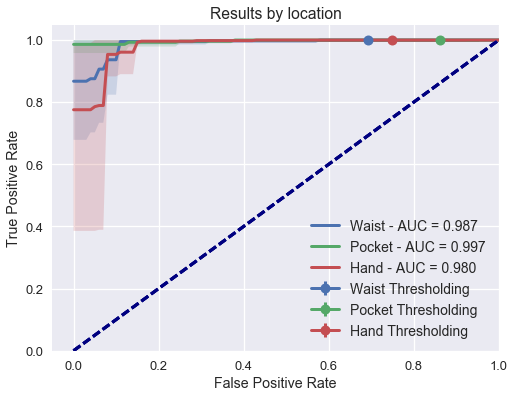

In [1141]:
sns.set_context('talk')
locs = [1,2,3]
fig = plt.figure(figsize=(8,6))
ax1=None

#remove subjects with no falls for some locations
Amp = Amp[(Amp.SubjID!=1)|(Amp.Loc!=2)]
Amp = Amp[(Amp.SubjID!=6)|((Amp.Loc!=2)&(Amp.Loc!=3))]

locAUC=[]

for l,name in zip(locs,['Waist','Pocket','Hand']):
    
    #filter amputees data (test data)
    Ampdata = Amp[Amp.Loc==l]
    
    AUC_all_HA, fpr_all_HA, tpr_all_HA, Sens_all_HA, Spec_all_HA, TTPR_allHA, TFPR_allHA, _, _ = EvaluateBySubject(Healthy,Ampdata)

    locAUC.append(AUC_all_HA)
    
    TTPR_allHA = np.asarray(TTPR_allHA)
    TFPR_allHA = np.asarray(TFPR_allHA)

    tprmu = np.mean(TTPR_allHA)
    tprerr = np.std(TTPR_allHA)/math.sqrt(len(TTPR_allHA))*1.96
    fprmu = np.mean(TFPR_allHA)
    fprerr = np.std(TFPR_allHA)/math.sqrt(len(TFPR_allHA))*1.96
    
#     ax1 = fig.add_subplot(2,2,l) #uncomment this line to generate subplots
    ax1 = plot_roc(tpr_all_HA,fpr_all_HA,np.mean(AUC_all_HA),ax1,plotname=name,col=current_palette[l-1])
    ax1.errorbar(fprmu,tprmu,xerr = fprerr,yerr = tprerr, ecolor = current_palette[l-1],
                 marker='.',mec=current_palette[l-1],mfc=current_palette[l-1],ms=20,lw=3,color = current_palette[l-1],
                 label='%s Thresholding' %(name))

ax1.set_title('Results by location')
ax1.legend(loc=4,fontsize = 14)

In [1142]:
[t_value, p_value] = stats.ttest_ind(locAUC[0],locAUC[1],equal_var=False)
print('Waist vs. Pocket %0.3f'%(p_value))

[t_value, p_value] = stats.ttest_ind(locAUC[0],locAUC[2],equal_var=False)
print('Waist vs. Hand %0.3f'%(p_value))

[t_value, p_value] = stats.ttest_ind(locAUC[1],locAUC[2],equal_var=False)
print('Pocket vs. Hand %0.3f'%(p_value))

Waist vs. Pocket 0.337
Waist vs. Hand 0.712
Pocket vs. Hand 0.393


In [1143]:
fig = ax1.get_figure()
fig.savefig('./Figs/Fig3.jpg')
fig.savefig('./Figs/Fig3.tif')

# Home data analysis

In [1144]:
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Homedata = pd.read_csv('./Data/HomeData.csv',header=None)
Homedata = Homedata.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})
Homedata.Falltype = 0
Amp.loc[Amp.Falltype<9,'Falltype'] = 1
Amp.loc[Amp.Falltype==9,'Falltype'] = 0

In [1145]:
homesubj = Homedata.SubjID.unique()

In [1146]:
homesubj

array([1, 6, 7], dtype=int64)

In [1147]:
for s in homesubj:
    Homedata = pd.concat([Amp[(Amp.SubjID==s) & (Amp.Falltype==1)],Homedata],axis=0)

In [1148]:
Homedata.shape

(3092, 1215)

In [1149]:
Homedata

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
130,7,1,0,1,0.345590,0.092185,-0.069031,-0.051326,-0.057101,0.005613,...,1.77230,2.94680,1.92190,-0.116210,0.70733,0.31827,0.62481,0.42696,3.05100,1.535000
131,7,1,0,1,0.439750,0.181280,-0.054606,-0.041979,-0.060627,0.007145,...,1.16320,-0.19768,1.37100,-0.277380,12.89900,3.81690,4.37390,4.07860,57.64400,4.230600
132,7,1,0,1,0.413320,0.192410,-0.090221,-0.044696,-0.053649,0.003373,...,1.27380,0.39833,1.37100,-0.002321,2.05760,1.14970,0.37798,0.40947,9.70990,1.837200
133,7,1,0,1,-0.562280,-0.340100,0.125410,-0.060538,-0.064292,0.004161,...,2.16830,4.73490,1.37100,-0.483590,0.37400,0.22128,0.63142,0.50891,0.86526,1.203000
134,7,1,0,1,-0.543680,-0.284050,0.045471,-0.057022,-0.064169,0.003641,...,0.82146,-2.10400,1.37100,-0.758480,0.50380,0.66709,0.80257,0.64374,0.63470,1.709200
135,7,1,0,1,-0.567450,-0.292140,0.291380,-0.054128,-0.064433,0.005678,...,1.87880,3.73610,1.92190,-0.422980,0.36443,0.61864,0.32795,0.42600,0.68353,0.986880
136,7,1,0,1,0.306510,-0.064877,0.228910,0.028107,-0.088593,0.010071,...,2.23090,4.98160,0.72193,-0.088850,0.71635,0.58196,0.44670,0.46523,3.05740,1.679300
137,7,1,0,1,-0.652580,0.013163,0.183830,-0.122030,-0.083137,-0.038932,...,1.60650,2.13290,1.37100,0.093467,0.29251,0.22057,0.28801,0.46647,0.31134,1.052000
138,7,1,0,1,-0.656690,-0.099764,0.063733,-0.220180,-0.121070,0.009766,...,1.94890,3.80860,1.92190,-0.471950,0.56907,0.61973,0.52809,0.46083,2.18930,1.293600
139,7,1,0,1,0.126920,0.069122,0.307330,-0.028488,-0.069977,0.065876,...,1.32330,0.68939,1.37100,-0.510830,0.41629,0.35613,0.63344,0.65215,0.96821,1.131900


In [1150]:
Spec_all, TSpec_all = HomeDataEval(Healthy,Homedata,TOpt)
print(Spec_all)
print(TSpec_all)

[0.90990990990990994, 0.92682926829268297, 0.87179487179487181]
[0.45045045045045046, 0.07991696938245978, 0.2937062937062937]


In [1077]:
Spec_all, TSpec_all = HomeDataEval(Healthy,Homedata,T90)
print(Spec_all)
print(TSpec_all)

[0.963963963963964, 0.9792423456149455, 0.92773892773892774]
[0.45045045045045046, 0.07991696938245978, 0.2937062937062937]


In [988]:
fig = ax2.get_figure()
fig.savefig('./Figs/Fig4.jpg')
fig.savefig('./Figs/Fig4.tif')

In [989]:
AUC_all_HA, fpr_all_HA, tpr_all_HA, Sens_all_HA, Spec_all_HA, TTPR_allHA, TFPR_allHA = EvaluateBySubject(Healthy,Homedata)

[ 0.7    0.824  0.88   0.92 ]
[ 0.449  0.518  0.554  0.636]
[ 0.82  0.94  0.96  0.98]
mean AUC = 0.979 (+/- 0.017)
mean Sens = 0.972 (+/- 0.039)
mean Spec = 0.923 (+/- 0.052)


In [991]:
for i in range(0,3):
    print(np.argmin(abs(tpr_all_HA[i]-.95)))
    

4
9
6


# Misc stuff to clean later

In [ ]:
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    #Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
    #print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Amputees - Random forest')
plt.legend(loc="lower right")

In [ ]:
#LOSO CV
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]

    xgb1.fit(Xtr,ytr)
    ypred = xgb1.predict(Xte)
    yscore = xgb1.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
#    print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - XGboost forest')
plt.legend(loc="lower right")

In [ ]:
print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))

See here on XGBoost params
http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

as well as here
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
xgb1.get_params()

In [ ]:
xgb1.fit(Xtr,ytr,eval_metric='auc')

In [ ]:
pred = xgb1.predict(Xte)

In [ ]:
pred_prob = xgb1.predict_proba(Xte)

In [ ]:
pred_prob.shape

In [ ]:
X = Xin.drop(['SubjID','Loc','Subjtype'],axis=1)
X.head(3)

In [ ]:
xgtrain = xgb.DMatrix(X,label='Falltype')
xgtest = xgb.DMatrix(Xte,label='Falltype')

In [ ]:
print xgtrain.num_col()
print xgtrain.num_row()
print xgtest.num_col()
print xgtest.num_row()

Look at the clips

In [ ]:
labels = sio.loadmat('./Data/accHealthy10.mat')

In [ ]:
acc = labels['acc']

In [ ]:
acc.shape

In [ ]:
i

In [ ]:
i = np.random.permutation(fpidx4)
i = i[0]
a = acc[i][0][:,1:]
plt.plot(a)

In [ ]:
np.where(Healthy.Falltype == 0)

In [ ]:
acc